# Dependency Installation

In [1]:
!pip3 install ultralytics

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118


In [59]:
!pip install easyocr

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------- ----------------------------- 0.8/2.9 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 2.9/2.9 MB 8.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
   ----- ---------------------------------- 5.2/39.4 MB 29.0 MB/s eta 0:00:02
   ------------- -------------------------- 13.1/39.4 MB 32.9 MB/s eta 0:00:01
   ----------------------- ---------------- 23.3/39.4 MB 37.8 MB/s eta 0:00:01
   -------------------------------- ------- 32.5/39.4 MB 39.7 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.4 MB 40.9 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.4 MB 40.9 MB/s eta 0:00:01
   ---------------------------------------- 39.4/39.4 MB 27.5 MB/s eta 0:00:00
   -------

In [68]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


# Import Libraries

In [1]:
import cv2
from ultralytics import YOLO
import torch

from IPython.display import display
from PIL import Image

import os
import time

import numpy as np
import pandas as pd
import easyocr as ocr

import threading
import multiprocessing

# Fine Tuning

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())  # Should print True
print(torch.version.cuda) 

2.6.0+cu118
True
11.8


In [3]:
# import the smallest pretrained yolov11 model
model = YOLO("yolo11n.pt")

In [ ]:
# fine tune the model
train_results = model.train(
    data="data.yaml",
    epochs=50,
    imgsz=416,
    device="cuda",  # Use GPU
    workers=0,  # Prevent multiprocessing error on Windows
    amp=False,  # Disable AMP for GTX 1650 Ti to prevent NaN losses,
)

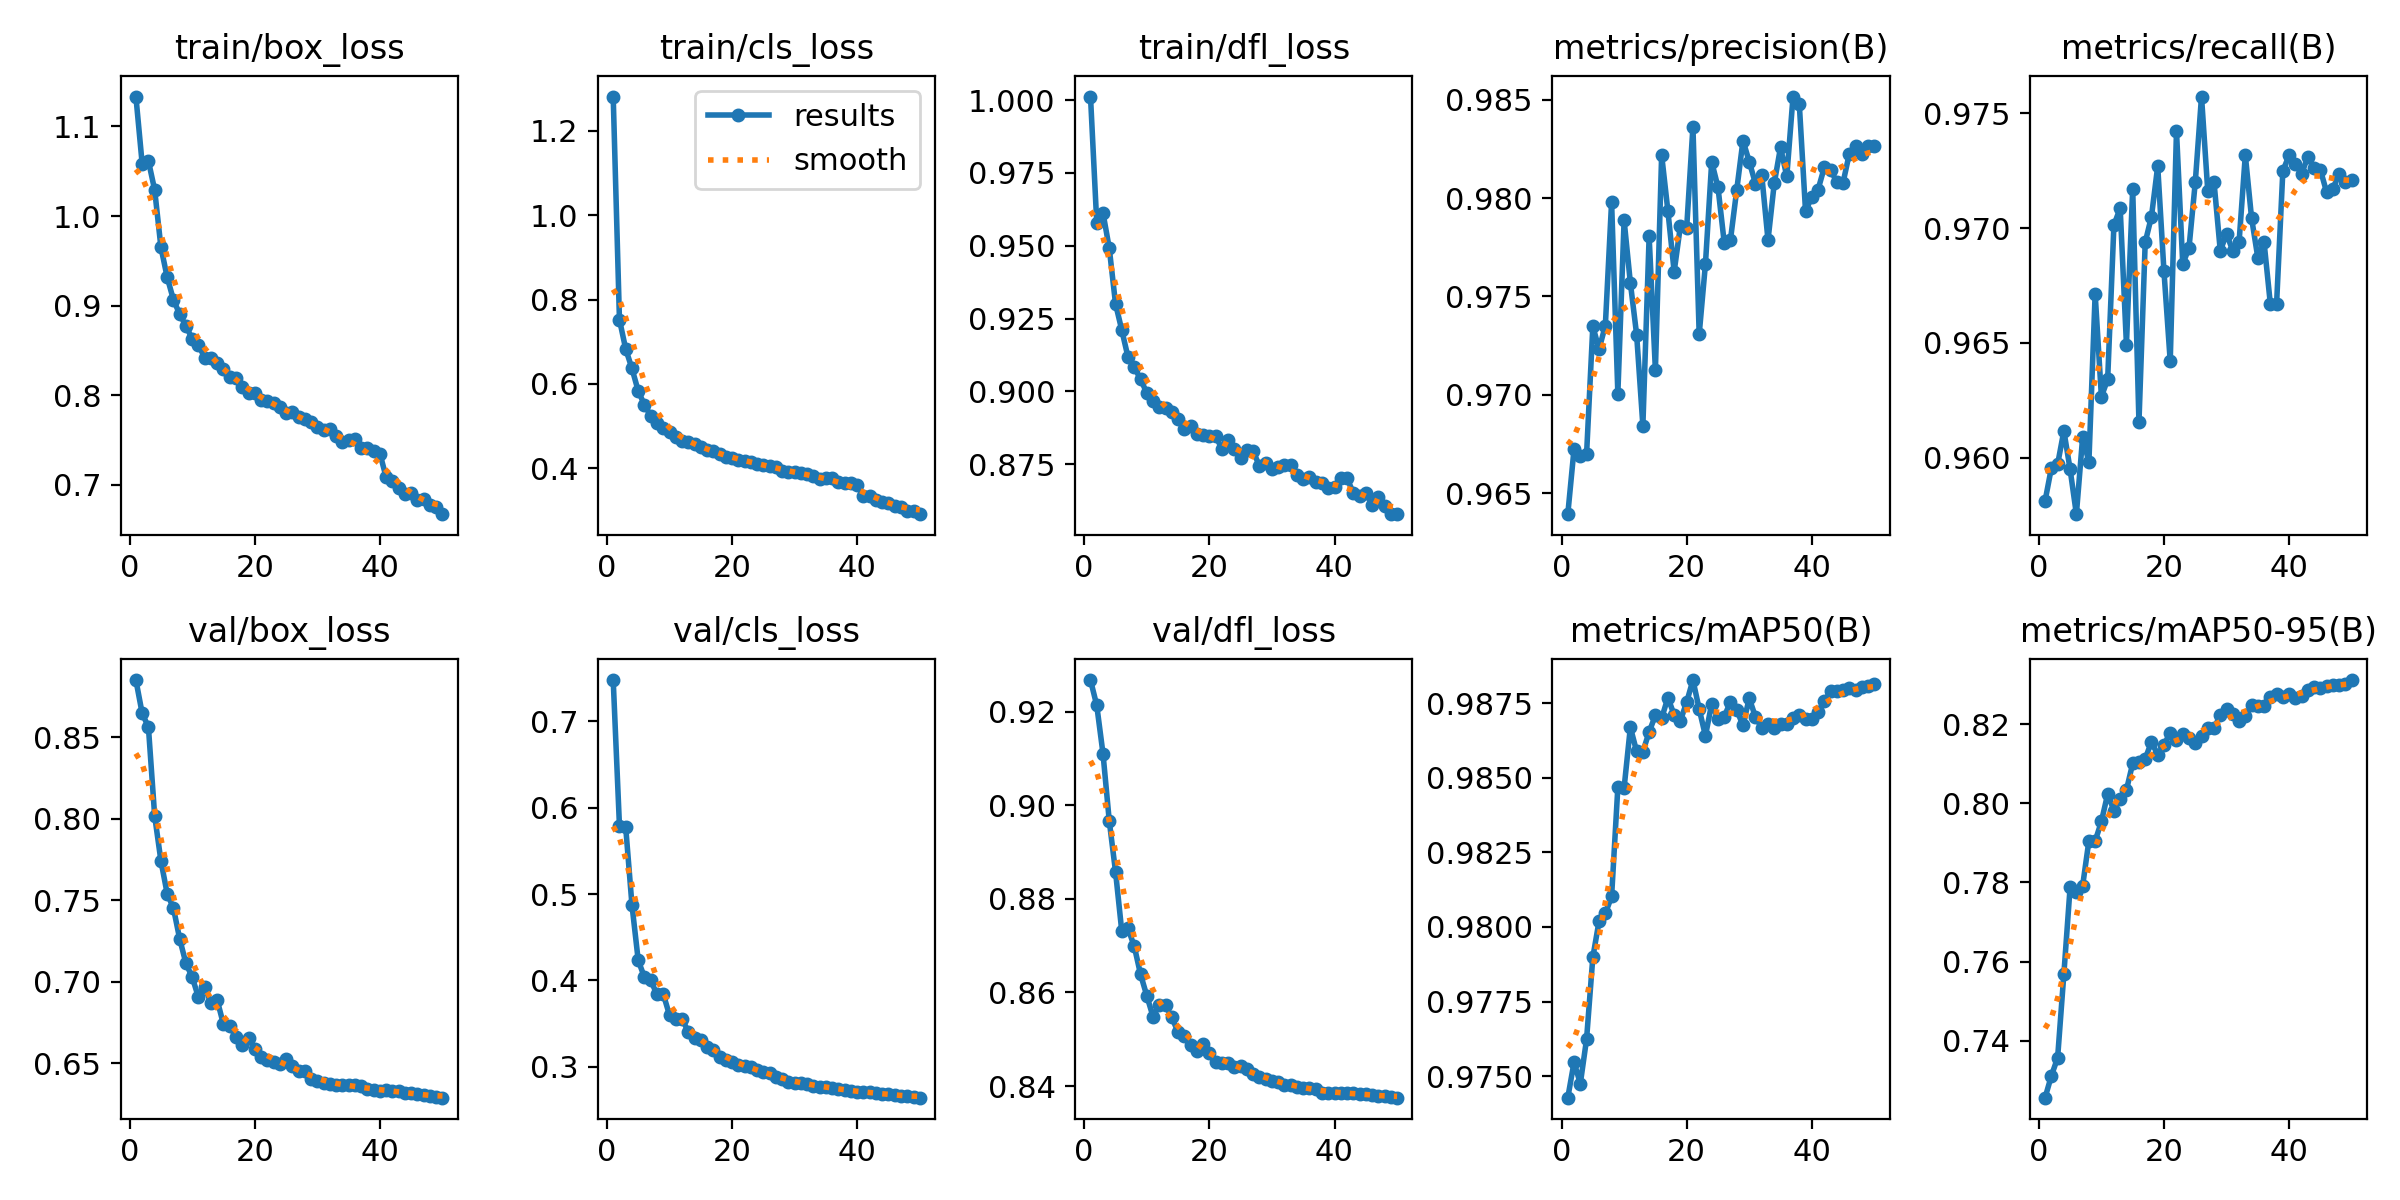

In [4]:
train_results = Image.open("runs/detect/train7/results.png")
display(train_results)

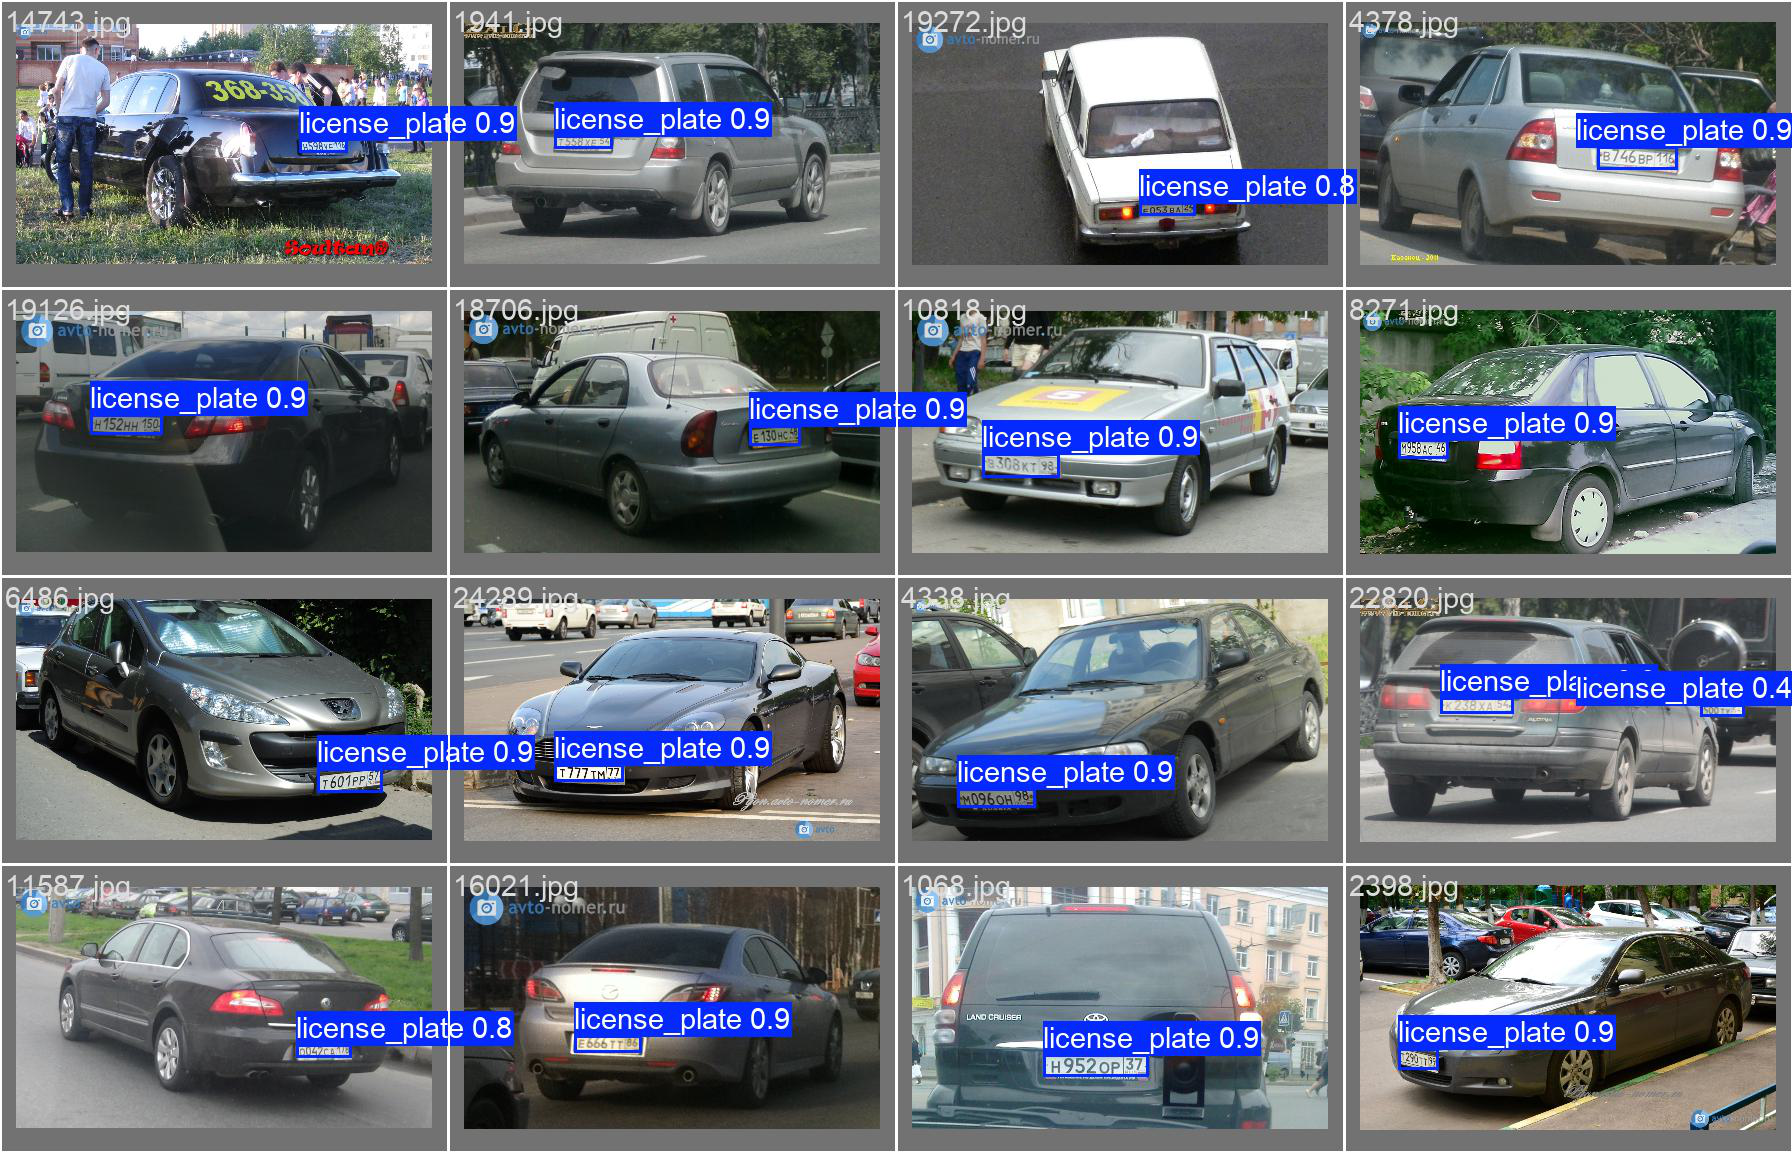

In [5]:
sample_val = Image.open("runs/detect/train7/val_batch2_pred.jpg")
display(sample_val)

# Prediction

In [6]:
model_dir = "runs/detect/train7/weights/best.pt"
model = YOLO(model_dir)

In [7]:
path = "C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/"
img_files = os.listdir(path)
img_dir = [path + x for x in img_files]
print("Number Images in '", path, "' :", len(img_dir))

Number Images in ' C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/ ' : 2564


In [8]:
def get_plate(boxes, image, reader):
    x_min, y_min, x_max, y_max = map(round, boxes)
    cropped = image[y_min:y_max,x_min:x_max]
    ocr_result = reader.readtext(cropped)

    # get the box with the largest area
    areas = []
    for i, (bbox, text, conf) in enumerate(ocr_result):
        [x1,y1], [x2,y2], [x3,y3], [x4,y4] = bbox
        
        x_values = [x1,x2,x3,x4]
        y_values = [y1,y2,y3,y4]
        width = max(x_values) - min(x_values)
        height = max(y_values) - min(y_values)
        area = width * height
        areas.append(area)

    results = []
    for each in sorted(areas, reverse=True):
        index = areas.index(each)
        results.append(ocr_result[index][1])
    return results

### Sequential

In [9]:
reader = ocr.Reader(['en'])

num_batches = 64

batch_size = len(img_dir) // num_batches + (len(img_dir) % num_batches > 0)

results_seq = []

start = time.time()
for i in range(0, len(img_dir), batch_size):
    print(f"Batch:{i//batch_size}")
    batch_dir = img_dir[i : i + batch_size]
    batch_files = img_files[i : i + batch_size]
    pred = model(batch_dir, stream=True)

    for result, file_name, img in zip(pred, batch_files, batch_dir):
        image = cv2.imread(img)
        #Error Check
        if image is None:
            print(f"Error reading image: {img}")
            continue
        try:
            boxes = result.boxes.xyxy.cpu()[0].numpy().tolist()
            ocr_results = get_plate(boxes, image, reader)
        except:
            print(f"Error getting ocr from image: {img}")
            ocr_results = ["N/A"]
            
        row = [file_name] + ocr_results
        results_seq.append(row)
        
        del image
        torch.cuda.empty_cache()

    del pred
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

end = time.time()

Batch:0

0: 416x416 1 license_plate, 1.8ms
1: 416x416 1 license_plate, 1.8ms
2: 416x416 1 license_plate, 1.8ms
3: 416x416 1 license_plate, 1.8ms
4: 416x416 1 license_plate, 1.8ms
5: 416x416 1 license_plate, 1.8ms
6: 416x416 1 license_plate, 1.8ms
7: 416x416 1 license_plate, 1.8ms
8: 416x416 1 license_plate, 1.8ms
9: 416x416 1 license_plate, 1.8ms
10: 416x416 1 license_plate, 1.8ms
11: 416x416 1 license_plate, 1.8ms
12: 416x416 1 license_plate, 1.8ms
13: 416x416 1 license_plate, 1.8ms
14: 416x416 1 license_plate, 1.8ms
15: 416x416 1 license_plate, 1.8ms
16: 416x416 1 license_plate, 1.8ms
17: 416x416 1 license_plate, 1.8ms
18: 416x416 1 license_plate, 1.8ms
19: 416x416 1 license_plate, 1.8ms
20: 416x416 1 license_plate, 1.8ms
21: 416x416 1 license_plate, 1.8ms
22: 416x416 2 license_plates, 1.8ms
23: 416x416 1 license_plate, 1.8ms
24: 416x416 1 license_plate, 1.8ms
25: 416x416 1 license_plate, 1.8ms
26: 416x416 1 license_plate, 1.8ms
27: 416x416 2 license_plates, 1.8ms
28: 416x416 1 licen

In [10]:
csv_filename = f"ocr_results_seq_{num_batches}.csv"
pd.DataFrame(results_seq).to_csv(csv_filename, index=False, header=False)

print(f"Results saved to {csv_filename}")

Results saved to ocr_results_seq_64.csv


In [11]:
print(f"Total Processing Time: {end-start} seconds")

Total Processing Time: 143.05408906936646 seconds


In [12]:
reader = ocr.Reader(['en'])

num_batches = 32

batch_size = len(img_dir) // num_batches + (len(img_dir) % num_batches > 0)

results_seq = []

start = time.time()
for i in range(0, len(img_dir), batch_size):
    print(f"Batch:{i//batch_size}")
    batch_dir = img_dir[i : i + batch_size]
    batch_files = img_files[i : i + batch_size]
    pred = model(batch_dir, stream=True)

    for result, file_name, img in zip(pred, batch_files, batch_dir):
        image = cv2.imread(img)
        #Error Check
        if image is None:
            print(f"Error reading image: {img}")
            continue
        try:
            boxes = result.boxes.xyxy.cpu()[0].numpy().tolist()
            ocr_results = get_plate(boxes, image, reader)
        except:
            print(f"Error getting ocr from image: {img}")
            ocr_results = ["N/A"]
            
        row = [file_name] + ocr_results
        results_seq.append(row)
        
        del image
        torch.cuda.empty_cache()

    del pred
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

end = time.time()

Batch:0

0: 416x416 1 license_plate, 4.2ms
1: 416x416 1 license_plate, 4.2ms
2: 416x416 1 license_plate, 4.2ms
3: 416x416 1 license_plate, 4.2ms
4: 416x416 1 license_plate, 4.2ms
5: 416x416 1 license_plate, 4.2ms
6: 416x416 1 license_plate, 4.2ms
7: 416x416 1 license_plate, 4.2ms
8: 416x416 1 license_plate, 4.2ms
9: 416x416 1 license_plate, 4.2ms
10: 416x416 1 license_plate, 4.2ms
11: 416x416 1 license_plate, 4.2ms
12: 416x416 1 license_plate, 4.2ms
13: 416x416 1 license_plate, 4.2ms
14: 416x416 1 license_plate, 4.2ms
15: 416x416 1 license_plate, 4.2ms
16: 416x416 1 license_plate, 4.2ms
17: 416x416 1 license_plate, 4.2ms
18: 416x416 1 license_plate, 4.2ms
19: 416x416 1 license_plate, 4.2ms
20: 416x416 1 license_plate, 4.2ms
21: 416x416 1 license_plate, 4.2ms
22: 416x416 2 license_plates, 4.2ms
23: 416x416 1 license_plate, 4.2ms
24: 416x416 1 license_plate, 4.2ms
25: 416x416 1 license_plate, 4.2ms
26: 416x416 1 license_plate, 4.2ms
27: 416x416 2 license_plates, 4.2ms
28: 416x416 1 licen

In [13]:
csv_filename = f"ocr_results_seq_{num_batches}.csv"
pd.DataFrame(results_seq).to_csv(csv_filename, index=False, header=False)

print(f"Results saved to {csv_filename}")

Results saved to ocr_results_seq_32.csv


In [14]:
print(f"Total Processing Time: {end-start} seconds")

Total Processing Time: 146.66839385032654 seconds


### Multithreading

In [15]:
reader = ocr.Reader(['en'])

num_threads = 1

num_batches = 64

thread_size = len(img_dir) // num_threads + (len(img_dir) % num_threads > 0)

batch_size = thread_size // num_batches + (thread_size % num_batches > 0)


class OCRThread(threading.Thread):
    def __init__(self, thread_dir, thread_files, thread_id):
        threading.Thread.__init__(self)
        self.thread_dir = thread_dir
        self.thread_files = thread_files
        self.thread_id = thread_id
        self.results = []

    def run(self):
        for i in range(0, len(self.thread_dir), batch_size):
            batch_dir = self.thread_dir[i:i + batch_size]
            batch_files = self.thread_files[i:i + batch_size]
            pred = model(batch_dir, stream=True)
        
            for result, file_name, img in zip(pred, batch_files, batch_dir):
                image = cv2.imread(img)
                
                if image is None:
                    print(f"Error reading image: {img}")
                    continue
                try:
                    boxes = result.boxes.xyxy.cpu()[0].numpy().tolist()
                    ocr_results = get_plate(boxes, image, reader)
                except:
                    print(f"Error getting ocr from image: {img}")
                    ocr_results = ["N/A"]
                    
                row = [file_name] + ocr_results
                self.results.append(row)
                
                del image
                torch.cuda.empty_cache()

            del pred
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        print(f"Thread {self.thread_id} complete") 

if __name__ == "__main__":
    start_mt = time.time()
    threads = []

    for i in range(0, len(img_dir), thread_size): 
        thread_dir = img_dir[i:i + thread_size]
        thread_files = img_files[i:i + thread_size]
        thread = OCRThread(thread_dir, thread_files, i // thread_size)
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    end_mt = time.time()

    results_mt = []
    for thread in threads:
        for row in thread.results:
            results_mt.append(row)
    
    csv_filename = f"ocr_results_multithreading_{num_threads}_{num_batches}.csv"
    pd.DataFrame(results_mt).to_csv(csv_filename, index=False, header=False)
    
    print(f"Results saved to {csv_filename}")

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mt - start_mt} seconds")


0: 416x416 1 license_plate, 7.6ms
1: 416x416 1 license_plate, 7.6ms
2: 416x416 1 license_plate, 7.6ms
3: 416x416 1 license_plate, 7.6ms
4: 416x416 1 license_plate, 7.6ms
5: 416x416 1 license_plate, 7.6ms
6: 416x416 1 license_plate, 7.6ms
7: 416x416 1 license_plate, 7.6ms
8: 416x416 1 license_plate, 7.6ms
9: 416x416 1 license_plate, 7.6ms
10: 416x416 1 license_plate, 7.6ms
11: 416x416 1 license_plate, 7.6ms
12: 416x416 1 license_plate, 7.6ms
13: 416x416 1 license_plate, 7.6ms
14: 416x416 1 license_plate, 7.6ms
15: 416x416 1 license_plate, 7.6ms
16: 416x416 1 license_plate, 7.6ms
17: 416x416 1 license_plate, 7.6ms
18: 416x416 1 license_plate, 7.6ms
19: 416x416 1 license_plate, 7.6ms
20: 416x416 1 license_plate, 7.6ms
21: 416x416 1 license_plate, 7.6ms
22: 416x416 2 license_plates, 7.6ms
23: 416x416 1 license_plate, 7.6ms
24: 416x416 1 license_plate, 7.6ms
25: 416x416 1 license_plate, 7.6ms
26: 416x416 1 license_plate, 7.6ms
27: 416x416 2 license_plates, 7.6ms
28: 416x416 1 license_plate

In [ ]:
reader = ocr.Reader(['en'])

num_threads = 2

num_batches = 32

thread_size = len(img_dir) // num_threads + (len(img_dir) % num_threads > 0)

batch_size = thread_size // num_batches + (thread_size % num_batches > 0)


class OCRThread(threading.Thread):
    def __init__(self, thread_dir, thread_files, thread_id):
        threading.Thread.__init__(self)
        self.thread_dir = thread_dir
        self.thread_files = thread_files
        self.thread_id = thread_id
        self.results = []

    def run(self):
        for i in range(0, len(self.thread_dir), batch_size):
            batch_dir = self.thread_dir[i:i + batch_size]
            batch_files = self.thread_files[i:i + batch_size]
            pred = model(batch_dir, stream=True)
        
            for result, file_name, img in zip(pred, batch_files, batch_dir):
                image = cv2.imread(img)
                
                if image is None:
                    print(f"Error reading image: {img}")
                    continue
                try:
                    boxes = result.boxes.xyxy.cpu()[0].numpy().tolist()
                    ocr_results = get_plate(boxes, image, reader)
                except:
                    print(f"Error getting ocr from image: {img}")
                    ocr_results = ["N/A"]
                    
                row = [file_name] + ocr_results
                self.results.append(row)
                
                del image
                torch.cuda.empty_cache()

            del pred
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        print(f"Thread {self.thread_id} complete") 

if __name__ == "__main__":
    start_mt = time.time()
    threads = []

    for i in range(0, len(img_dir), thread_size): 
        thread_dir = img_dir[i:i + thread_size]
        thread_files = img_files[i:i + thread_size]
        thread = OCRThread(thread_dir, thread_files, i // thread_size)
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    end_mt = time.time()

    results_mt = []
    for thread in threads:
        for row in thread.results:
            results_mt.append(row)
    
    csv_filename = f"ocr_results_multithreading_{num_threads}_{num_batches}.csv"
    pd.DataFrame(results_mt).to_csv(csv_filename, index=False, header=False)
    
    print(f"Results saved to {csv_filename}")

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mt - start_mt} seconds")

Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "C:\Users\Monica\AppData\Local\Temp\ipykernel_21432\257885309.py", line 24, in run
  File "C:\Users\Monica\AppData\Roaming\Python\Python312\site-packages\ultralytics\engine\model.py", line 182, in __call__
    return self.predict(source, stream, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Monica\AppData\Roaming\Python\Python312\site-packages\ultralytics\engine\model.py", line 553, in predict
    self.predictor.setup_model(model=self.model, verbose=is_cli)
  File "C:\Users\Monica\AppData\Roaming\Python\Python312\site-packages\ultralytics\engine\predictor.py", line 310, in setup_model
    self.model = AutoBackend(
                 ^^^^^^^^^^^^
  File "C:\Users\Monica\AppData\Roaming\Python\Python312\site-packages\torch\utils\_contextlib.py", line 116, in decorate_context
    return func(*


0: 416x416 (no detections), 2.1ms
1: 416x416 (no detections), 2.1ms
2: 416x416 (no detections), 2.1ms
3: 416x416 (no detections), 2.1ms
4: 416x416 (no detections), 2.1ms
5: 416x416 (no detections), 2.1ms
6: 416x416 (no detections), 2.1ms
7: 416x416 (no detections), 2.1ms
8: 416x416 (no detections), 2.1ms
9: 416x416 (no detections), 2.1ms
10: 416x416 (no detections), 2.1ms
11: 416x416 (no detections), 2.1ms
12: 416x416 (no detections), 2.1ms
13: 416x416 (no detections), 2.1ms
14: 416x416 (no detections), 2.1ms
15: 416x416 (no detections), 2.1ms
16: 416x416 (no detections), 2.1ms
17: 416x416 (no detections), 2.1ms
18: 416x416 (no detections), 2.1ms
19: 416x416 (no detections), 2.1ms
20: 416x416 (no detections), 2.1ms
21: 416x416 (no detections), 2.1ms
22: 416x416 (no detections), 2.1ms
23: 416x416 (no detections), 2.1ms
24: 416x416 (no detections), 2.1ms
25: 416x416 (no detections), 2.1ms
26: 416x416 (no detections), 2.1ms
27: 416x416 (no detections), 2.1ms
28: 416x416 (no detections), 

In [14]:
reader = ocr.Reader(['en'])

num_threads = 4

num_batches = 16

thread_size = len(img_dir) // num_threads + (len(img_dir) % num_threads > 0)

batch_size = thread_size // num_batches + (thread_size % num_batches > 0)


class OCRThread(threading.Thread):
    def __init__(self, thread_dir, thread_files, thread_id):
        threading.Thread.__init__(self)
        self.thread_dir = thread_dir
        self.thread_files = thread_files
        self.thread_id = thread_id
        self.results = []

    def run(self):
        for i in range(0, len(self.thread_dir), batch_size):
            batch_dir = self.thread_dir[i:i + batch_size]
            batch_files = self.thread_files[i:i + batch_size]
            pred = model(batch_dir, stream=True)
        
            for result, file_name, img in zip(pred, batch_files, batch_dir):
                image = cv2.imread(img)
                
                if image is None:
                    print(f"Error reading image: {img}")
                    continue
                try:
                    boxes = result.boxes.xyxy.cpu()[0].numpy().tolist()
                    ocr_results = get_plate(boxes, image, reader)
                except:
                    print(f"Error getting ocr from image: {img}")
                    ocr_results = ["N/A"]
                    
                row = [file_name] + ocr_results
                self.results.append(row)
                
                del image
                torch.cuda.empty_cache()

            del pred
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        print(f"Thread {self.thread_id} complete") 

if __name__ == "__main__":
    start_mt = time.time()
    threads = []

    for i in range(0, len(img_dir), thread_size): 
        thread_dir = img_dir[i:i + thread_size]
        thread_files = img_files[i:i + thread_size]
        thread = OCRThread(thread_dir, thread_files, i // thread_size)
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    end_mt = time.time()

    results_mt = []
    for thread in threads:
        for row in thread.results:
            results_mt.append(row)
    
    csv_filename = f"ocr_results_multithreading_{num_threads}_{num_batches}.csv"
    pd.DataFrame(results_mt).to_csv(csv_filename, index=False, header=False)
    
    print(f"Results saved to {csv_filename}")

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mt - start_mt} seconds")





0: 416x416 1 license_plate, 4.9ms
1: 416x416 1 license_plate, 4.9ms
2: 416x416 1 license_plate, 4.9ms
3: 416x416 1 license_plate, 4.9ms
4: 416x416 1 license_plate, 4.9ms
5: 416x416 1 license_plate, 4.9ms
6: 416x416 1 license_plate, 4.9ms
7: 416x416 1 license_plate, 4.9ms
8: 416x416 1 license_plate, 4.9ms
9: 416x416 1 license_plate, 4.9ms
10: 416x416 1 license_plate, 4.9ms
11: 416x416 1 license_plate, 4.9ms
12: 416x416 1 license_plate, 4.9ms
13: 416x416 1 license_plate, 4.9ms
14: 416x416 1 license_plate, 4.9ms
15: 416x416 1 license_plate, 4.9ms
16: 416x416 1 license_plate, 4.9ms
17: 416x416 1 license_plate, 4.9ms
18: 416x416 1 license_plate, 4.9ms
19: 416x416 1 license_plate, 4.9ms
20: 416x416 1 license_plate, 4.9ms
21: 416x416 1 license_plate, 4.9ms
22: 416x416 2 license_plates, 4.9ms
23: 416x416 1 license_plate, 4.9ms
24: 416x416 1 license_plate, 4.9ms
25: 416x416 1 license_plate, 4.9ms
26: 416x416 1 license_plate, 4.9ms
27: 416x416 2 license_plates, 4.9ms
28: 416x416 1 license_pl

In [15]:
reader = ocr.Reader(['en'])

num_threads = 8

num_batches = 8

thread_size = len(img_dir) // num_threads + (len(img_dir) % num_threads > 0)

batch_size = thread_size // num_batches + (thread_size % num_batches > 0)


class OCRThread(threading.Thread):
    def __init__(self, thread_dir, thread_files, thread_id):
        threading.Thread.__init__(self)
        self.thread_dir = thread_dir
        self.thread_files = thread_files
        self.thread_id = thread_id
        self.results = []

    def run(self):
        for i in range(0, len(self.thread_dir), batch_size):
            batch_dir = self.thread_dir[i:i + batch_size]
            batch_files = self.thread_files[i:i + batch_size]
            pred = model(batch_dir, stream=True)
        
            for result, file_name, img in zip(pred, batch_files, batch_dir):
                image = cv2.imread(img)
                
                if image is None:
                    print(f"Error reading image: {img}")
                    continue
                try:
                    boxes = result.boxes.xyxy.cpu()[0].numpy().tolist()
                    ocr_results = get_plate(boxes, image, reader)
                except:
                    print(f"Error getting ocr from image: {img}")
                    ocr_results = ["N/A"]
                    
                row = [file_name] + ocr_results
                self.results.append(row)
                
                del image
                torch.cuda.empty_cache()

            del pred
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        print(f"Thread {self.thread_id} complete") 

if __name__ == "__main__":
    start_mt = time.time()
    threads = []

    for i in range(0, len(img_dir), thread_size): 
        thread_dir = img_dir[i:i + thread_size]
        thread_files = img_files[i:i + thread_size]
        thread = OCRThread(thread_dir, thread_files, i // thread_size)
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    end_mt = time.time()

    results_mt = []
    for thread in threads:
        for row in thread.results:
            results_mt.append(row)
    
    csv_filename = f"ocr_results_multithreading_{num_threads}_{num_batches}.csv"
    pd.DataFrame(results_mt).to_csv(csv_filename, index=False, header=False)
    
    print(f"Results saved to {csv_filename}")

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mt - start_mt} seconds")









0: 416x416 1 license_plate, 7.7ms
1: 416x416 1 license_plate, 7.7ms
2: 416x416 1 license_plate, 7.7ms
3: 416x416 1 license_plate, 7.7ms
4: 416x416 1 license_plate, 7.7ms
5: 416x416 1 license_plate, 7.7ms
6: 416x416 1 license_plate, 7.7ms
7: 416x416 1 license_plate, 7.7ms
8: 416x416 1 license_plate, 7.7ms
9: 416x416 1 license_plate, 7.7ms
10: 416x416 1 license_plate, 7.7ms
11: 416x416 1 license_plate, 7.7ms
12: 416x416 1 license_plate, 7.7ms
13: 416x416 1 license_plate, 7.7ms
14: 416x416 1 license_plate, 7.7ms
15: 416x416 1 license_plate, 7.7ms
16: 416x416 1 license_plate, 7.7ms
17: 416x416 1 license_plate, 7.7ms
18: 416x416 1 license_plate, 7.7ms
19: 416x416 1 license_plate, 7.7ms
20: 416x416 1 license_plate, 7.7ms
21: 416x416 1 license_plate, 7.7ms
22: 416x416 2 license_plates, 7.7ms
23: 416x416 1 license_plate, 7.7ms
24: 416x416 1 license_plate, 7.7ms
25: 416x416 1 license_plate, 7.7ms
26: 416x416 1 license_plate, 7.7ms
27: 416x416 2 license_plates, 7.7ms
28: 416x416 1 licens

In [16]:
reader = ocr.Reader(['en'])

num_threads = 16

num_batches = 4

thread_size = len(img_dir) // num_threads + (len(img_dir) % num_threads > 0)

batch_size = thread_size // num_batches + (thread_size % num_batches > 0)


class OCRThread(threading.Thread):
    def __init__(self, thread_dir, thread_files, thread_id):
        threading.Thread.__init__(self)
        self.thread_dir = thread_dir
        self.thread_files = thread_files
        self.thread_id = thread_id
        self.results = []

    def run(self):
        for i in range(0, len(self.thread_dir), batch_size):
            batch_dir = self.thread_dir[i:i + batch_size]
            batch_files = self.thread_files[i:i + batch_size]
            pred = model(batch_dir, stream=True)
        
            for result, file_name, img in zip(pred, batch_files, batch_dir):
                image = cv2.imread(img)
                
                if image is None:
                    print(f"Error reading image: {img}")
                    continue
                try:
                    boxes = result.boxes.xyxy.cpu()[0].numpy().tolist()
                    ocr_results = get_plate(boxes, image, reader)
                except:
                    print(f"Error getting ocr from image: {img}")
                    ocr_results = ["N/A"]
                    
                row = [file_name] + ocr_results
                self.results.append(row)
                
                del image
                torch.cuda.empty_cache()

            del pred
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        print(f"Thread {self.thread_id} complete") 

if __name__ == "__main__":
    start_mt = time.time()
    threads = []

    for i in range(0, len(img_dir), thread_size): 
        thread_dir = img_dir[i:i + thread_size]
        thread_files = img_files[i:i + thread_size]
        thread = OCRThread(thread_dir, thread_files, i // thread_size)
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    end_mt = time.time()

    results_mt = []
    for thread in threads:
        for row in thread.results:
            results_mt.append(row)
    
    csv_filename = f"ocr_results_multithreading_{num_threads}_{num_batches}.csv"
    pd.DataFrame(results_mt).to_csv(csv_filename, index=False, header=False)
    
    print(f"Results saved to {csv_filename}")

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mt - start_mt} seconds")

















0: 416x416 1 license_plate, 4.7ms
1: 416x416 1 license_plate, 4.7ms
2: 416x416 1 license_plate, 4.7ms
3: 416x416 1 license_plate, 4.7ms
4: 416x416 1 license_plate, 4.7ms
5: 416x416 1 license_plate, 4.7ms
6: 416x416 1 license_plate, 4.7ms
7: 416x416 1 license_plate, 4.7ms
8: 416x416 1 license_plate, 4.7ms
9: 416x416 1 license_plate, 4.7ms
10: 416x416 1 license_plate, 4.7ms
11: 416x416 1 license_plate, 4.7ms
12: 416x416 1 license_plate, 4.7ms
13: 416x416 1 license_plate, 4.7ms
14: 416x416 1 license_plate, 4.7ms
15: 416x416 1 license_plate, 4.7ms
16: 416x416 1 license_plate, 4.7ms
17: 416x416 1 license_plate, 4.7ms
18: 416x416 1 license_plate, 4.7ms
19: 416x416 1 license_plate, 4.7ms
20: 416x416 1 license_plate, 4.7ms
21: 416x416 1 license_plate, 4.7ms
22: 416x416 2 license_plates, 4.7ms
23: 416x416 1 license_plate, 4.7ms
24: 416x416 1 license_plate, 4.7ms
25: 416x416 1 license_plate, 4.7ms
26: 416x416 1 license_plate, 4.7ms
27: 416x416 2 license_plates, 4.7ms
28: 416x416 

In [17]:
reader = ocr.Reader(['en'])

num_threads = 32

num_batches = 2

thread_size = len(img_dir) // num_threads + (len(img_dir) % num_threads > 0)

batch_size = thread_size // num_batches + (thread_size % num_batches > 0)


class OCRThread(threading.Thread):
    def __init__(self, thread_dir, thread_files, thread_id):
        threading.Thread.__init__(self)
        self.thread_dir = thread_dir
        self.thread_files = thread_files
        self.thread_id = thread_id
        self.results = []

    def run(self):
        for i in range(0, len(self.thread_dir), batch_size):
            batch_dir = self.thread_dir[i:i + batch_size]
            batch_files = self.thread_files[i:i + batch_size]
            pred = model(batch_dir, stream=True)
        
            for result, file_name, img in zip(pred, batch_files, batch_dir):
                image = cv2.imread(img)
                
                if image is None:
                    print(f"Error reading image: {img}")
                    continue
                try:
                    boxes = result.boxes.xyxy.cpu()[0].numpy().tolist()
                    ocr_results = get_plate(boxes, image, reader)
                except:
                    print(f"Error getting ocr from image: {img}")
                    ocr_results = ["N/A"]
                    
                row = [file_name] + ocr_results
                self.results.append(row)
                
                del image
                torch.cuda.empty_cache()

            del pred
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        print(f"Thread {self.thread_id} complete") 

if __name__ == "__main__":
    start_mt = time.time()
    threads = []

    for i in range(0, len(img_dir), thread_size): 
        thread_dir = img_dir[i:i + thread_size]
        thread_files = img_files[i:i + thread_size]
        thread = OCRThread(thread_dir, thread_files, i // thread_size)
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    end_mt = time.time()

    results_mt = []
    for thread in threads:
        for row in thread.results:
            results_mt.append(row)
    
    csv_filename = f"ocr_results_multithreading_{num_threads}_{num_batches}.csv"
    pd.DataFrame(results_mt).to_csv(csv_filename, index=False, header=False)
    
    print(f"Results saved to {csv_filename}")

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mt - start_mt} seconds")

































0: 416x416 1 license_plate, 5.5ms
1: 416x416 1 license_plate, 5.5ms
2: 416x416 1 license_plate, 5.5ms
3: 416x416 1 license_plate, 5.5ms
4: 416x416 1 license_plate, 5.5ms
5: 416x416 1 license_plate, 5.5ms
6: 416x416 1 license_plate, 5.5ms
7: 416x416 1 license_plate, 5.5ms
8: 416x416 1 license_plate, 5.5ms
9: 416x416 1 license_plate, 5.5ms
10: 416x416 1 license_plate, 5.5ms
11: 416x416 1 license_plate, 5.5ms
12: 416x416 1 license_plate, 5.5ms
13: 416x416 1 license_plate, 5.5ms
14: 416x416 1 license_plate, 5.5ms
15: 416x416 1 license_plate, 5.5ms
16: 416x416 1 license_plate, 5.5ms
17: 416x416 1 license_plate, 5.5ms
18: 416x416 1 license_plate, 5.5ms
19: 416x416 1 license_plate, 5.5ms
20: 416x416 1 license_plate, 5.5ms
21: 416x416 1 license_plate, 5.5ms
22: 416x416 2 license_plates, 5.5ms
23: 416x416 1 license_plate, 5.5ms
24: 416x416 1 license_plate, 5.5ms
25: 416x416 1 license_plate, 5.5ms
26: 416x416 1 license_plate, 5.5ms
27: 416x416 2 license_plates, 5.

In [9]:
reader = ocr.Reader(['en'])

num_threads = 64

num_batches = 1

thread_size = len(img_dir) // num_threads + (len(img_dir) % num_threads > 0)

batch_size = thread_size // num_batches + (thread_size % num_batches > 0)


class OCRThread(threading.Thread):
    def __init__(self, thread_dir, thread_files, thread_id):
        threading.Thread.__init__(self)
        self.thread_dir = thread_dir
        self.thread_files = thread_files
        self.thread_id = thread_id
        self.results = []

    def run(self):
        for i in range(0, len(self.thread_dir), batch_size):
            batch_dir = self.thread_dir[i:i + batch_size]
            batch_files = self.thread_files[i:i + batch_size]
            pred = model(batch_dir, stream=True)
        
            for result, file_name, img in zip(pred, batch_files, batch_dir):
                image = cv2.imread(img)
                
                if image is None:
                    print(f"Error reading image: {img}")
                    continue
                try:
                    boxes = result.boxes.xyxy.cpu()[0].numpy().tolist()
                    ocr_results = get_plate(boxes, image, reader)
                except:
                    print(f"Error getting ocr from image: {img}")
                    ocr_results = ["N/A"]
                    
                row = [file_name] + ocr_results
                self.results.append(row)
                
                del image
                torch.cuda.empty_cache()

            del pred
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        print(f"Thread {self.thread_id} complete") 

if __name__ == "__main__":
    start_mt = time.time()
    threads = []

    for i in range(0, len(img_dir), thread_size): 
        thread_dir = img_dir[i:i + thread_size]
        thread_files = img_files[i:i + thread_size]
        thread = OCRThread(thread_dir, thread_files, i // thread_size)
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    end_mt = time.time()

    results_mt = []
    for thread in threads:
        for row in thread.results:
            results_mt.append(row)
    
    csv_filename = f"ocr_results_multithreading_{num_threads}_{num_batches}.csv"
    pd.DataFrame(results_mt).to_csv(csv_filename, index=False, header=False)
    
    print(f"Results saved to {csv_filename}")

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mt - start_mt} seconds")



Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)



Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)




Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)



Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)



Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)



Ultralytics 8.3.80  Python-3.12.

Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\threading.py", line 1075, in _bootstrap_inner
Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "C:\Users\Monica\AppData\Local\Temp\ipykernel_7868\4110402730.py", line 24, in run
    self.run()
  File "C:\Users\Monica\AppData\Local\Temp\ipykernel_7868\4110402730.py", line 24, in run
  File "C:\Users\Monica\AppData\Roaming\Python\Python312\site-packages\ultralytics\engine\model.py", line 182, in __call__
  File "C:\Users\Monica\AppData\Roaming\Python\Python312\site-packages\ultralytics\engine\model.py", line 182, in __call__
    return self.predict(source, stream, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Monica\AppData\Roaming\Python\Python312\site-packages\ultralytics\engine\model.py", line 553, in predict
    return self.predict(so

Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


    super().__delattr__(name)
AttributeError: 'Conv' object has no attribute 'bn'


Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Ultralytics 8.3.80  Python-3.12.7 torch-2.6.0+cu118 CUD

### Multiprocessing

In [9]:
from ocr_process import OCRProcess

reader = ocr.Reader(['en'])

num_processes = 1

num_batches = 64

process_size = len(img_dir) // num_processes + (len(img_dir) % num_processes > 0)

batch_size = process_size // num_batches + (process_size % num_batches > 0)

if __name__ == "__main__":
    manager = multiprocessing.Manager()
    results_mp = manager.list()
    log_queue = multiprocessing.Queue()
    
    start_mp = time.time()
    processes = []

    for i in range(0, len(img_dir), process_size): 
        process_dir = img_dir[i:i + process_size]
        process_files = img_files[i:i + process_size]
        process = OCRProcess(process_dir, process_files, results_mp, i // process_size, log_queue, model, batch_size)
        processes.append(process)
        process.start()

    while any(p.is_alive() for p in processes) or not log_queue.empty():
        while not log_queue.empty():
            print(log_queue.get())
   

    for process in processes:
        process.join()

    end_mp = time.time()

    csv_filename = f"ocr_results_multiprocessing_{num_processes}_{num_batches}.csv"
    pd.DataFrame(list(results_mp)).to_csv(csv_filename, index=False, header=False) 

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mp - start_mp} seconds")

Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/13733.jpg
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/14862.bmp
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/5174.jpg
Process 0 completed
Results saved to ocr_results_multiprocessing_1_64.csv
Total processing time: 161.41307759284973 seconds


In [10]:
from ocr_process import OCRProcess

reader = ocr.Reader(['en'])

num_processes = 2

num_batches = 32

process_size = len(img_dir) // num_processes + (len(img_dir) % num_processes > 0)

batch_size = process_size // num_batches + (process_size % num_batches > 0)

if __name__ == "__main__":
    manager = multiprocessing.Manager()
    results_mp = manager.list()
    log_queue = multiprocessing.Queue()
    
    start_mp = time.time()
    processes = []

    for i in range(0, len(img_dir), process_size): 
        process_dir = img_dir[i:i + process_size]
        process_files = img_files[i:i + process_size]
        process = OCRProcess(process_dir, process_files, results_mp, i // process_size, log_queue, model, batch_size)
        processes.append(process)
        process.start()

    while any(p.is_alive() for p in processes) or not log_queue.empty():
        while not log_queue.empty():
            print(log_queue.get())
   

    for process in processes:
        process.join()

    end_mp = time.time()

    csv_filename = f"ocr_results_multiprocessing_{num_processes}_{num_batches}.csv"
    pd.DataFrame(list(results_mp)).to_csv(csv_filename, index=False, header=False) 

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mp - start_mp} seconds")

Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/13733.jpg
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/14862.bmp
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/5174.jpg
Process 0 completed
Process 1 completed
Results saved to ocr_results_multiprocessing_2_32.csv
Total processing time: 112.74230122566223 seconds


In [11]:
from ocr_process import OCRProcess

reader = ocr.Reader(['en'])

num_processes = 4

num_batches = 16

process_size = len(img_dir) // num_processes + (len(img_dir) % num_processes > 0)

batch_size = process_size // num_batches + (process_size % num_batches > 0)

if __name__ == "__main__":
    manager = multiprocessing.Manager()
    results_mp = manager.list()
    log_queue = multiprocessing.Queue()
    
    start_mp = time.time()
    processes = []

    for i in range(0, len(img_dir), process_size): 
        process_dir = img_dir[i:i + process_size]
        process_files = img_files[i:i + process_size]
        process = OCRProcess(process_dir, process_files, results_mp, i // process_size, log_queue, model, batch_size)
        processes.append(process)
        process.start()

    while any(p.is_alive() for p in processes) or not log_queue.empty():
        while not log_queue.empty():
            print(log_queue.get())
   

    for process in processes:
        process.join()

    end_mp = time.time()

    csv_filename = f"ocr_results_multiprocessing_{num_processes}_{num_batches}.csv"
    pd.DataFrame(list(results_mp)).to_csv(csv_filename, index=False, header=False) 

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mp - start_mp} seconds")

Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/5174.jpg
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/13733.jpg
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/14862.bmp
Process 0 completed
Process 1 completed
Process 2 completed
Process 3 completed
Results saved to ocr_results_multiprocessing_4_16.csv
Total processing time: 96.69092750549316 seconds


In [12]:
from ocr_process import OCRProcess

reader = ocr.Reader(['en'])

num_processes = 8

num_batches = 8

process_size = len(img_dir) // num_processes + (len(img_dir) % num_processes > 0)

batch_size = process_size // num_batches + (process_size % num_batches > 0)

if __name__ == "__main__":
    manager = multiprocessing.Manager()
    results_mp = manager.list()
    log_queue = multiprocessing.Queue()
    
    start_mp = time.time()
    processes = []

    for i in range(0, len(img_dir), process_size): 
        process_dir = img_dir[i:i + process_size]
        process_files = img_files[i:i + process_size]
        process = OCRProcess(process_dir, process_files, results_mp, i // process_size, log_queue, model, batch_size)
        processes.append(process)
        process.start()

    while any(p.is_alive() for p in processes) or not log_queue.empty():
        while not log_queue.empty():
            print(log_queue.get())
   

    for process in processes:
        process.join()

    end_mp = time.time()

    csv_filename = f"ocr_results_multiprocessing_{num_processes}_{num_batches}.csv"
    pd.DataFrame(list(results_mp)).to_csv(csv_filename, index=False, header=False) 

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mp - start_mp} seconds")

Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/13733.jpg
Process 0 completed
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/14862.bmp
Process 1 completed
Process 2 completed
Process 3 completed
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/5174.jpg
Process 4 completed
Process 5 completed
Process 6 completed
Process 7 completed
Results saved to ocr_results_multiprocessing_8_8.csv
Total processing time: 108.83112382888794 seconds


In [13]:
from ocr_process import OCRProcess

reader = ocr.Reader(['en'])

num_processes = 16

num_batches = 4

process_size = len(img_dir) // num_processes + (len(img_dir) % num_processes > 0)

batch_size = process_size // num_batches + (process_size % num_batches > 0)

if __name__ == "__main__":
    manager = multiprocessing.Manager()
    results_mp = manager.list()
    log_queue = multiprocessing.Queue()
    
    start_mp = time.time()
    processes = []

    for i in range(0, len(img_dir), process_size): 
        process_dir = img_dir[i:i + process_size]
        process_files = img_files[i:i + process_size]
        process = OCRProcess(process_dir, process_files, results_mp, i // process_size, log_queue, model, batch_size)
        processes.append(process)
        process.start()

    while any(p.is_alive() for p in processes) or not log_queue.empty():
        while not log_queue.empty():
            print(log_queue.get())
   

    for process in processes:
        process.join()

    end_mp = time.time()

    csv_filename = f"ocr_results_multiprocessing_{num_processes}_{num_batches}.csv"
    pd.DataFrame(list(results_mp)).to_csv(csv_filename, index=False, header=False) 

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mp - start_mp} seconds")

Process 0 completed
Process 1 completed
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/13733.jpg
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/14862.bmp
Process 2 completed
Process 3 completed
Process 4 completed
Process 5 completed
Process 6 completed
Process 7 completed
Process 8 completed
Process 9 completed
Process 10 completed
Process 11 completed
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/5174.jpg
Process 12 completed
Process 13 completed
Process 14 completed
Process 15 completed
Results saved to ocr_results_multiprocessing_16_4.csv
Total processing time: 155.76268196105957 seconds


In [14]:
from ocr_process import OCRProcess

reader = ocr.Reader(['en'])

num_processes = 32

num_batches = 2

process_size = len(img_dir) // num_processes + (len(img_dir) % num_processes > 0)

batch_size = process_size // num_batches + (process_size % num_batches > 0)

if __name__ == "__main__":
    manager = multiprocessing.Manager()
    results_mp = manager.list()
    log_queue = multiprocessing.Queue()
    
    start_mp = time.time()
    processes = []

    for i in range(0, len(img_dir), process_size): 
        process_dir = img_dir[i:i + process_size]
        process_files = img_files[i:i + process_size]
        process = OCRProcess(process_dir, process_files, results_mp, i // process_size, log_queue, model, batch_size)
        processes.append(process)
        process.start()

    while any(p.is_alive() for p in processes) or not log_queue.empty():
        while not log_queue.empty():
            print(log_queue.get())
   

    for process in processes:
        process.join()

    end_mp = time.time()

    csv_filename = f"ocr_results_multiprocessing_{num_processes}_{num_batches}.csv"
    pd.DataFrame(list(results_mp)).to_csv(csv_filename, index=False, header=False) 

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mp - start_mp} seconds")

Process 0 completed
Process 1 completed
Process 2 completed
Process 3 completed
Process 4 completed
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/13733.jpg
Process 5 completed
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/14862.bmp
Process 6 completed
Process 7 completed
Process 8 completed
Process 9 completed
Process 10 completed
Process 11 completed
Process 12 completed
Process 13 completed
Process 14 completed
Process 15 completed
Process 16 completed
Process 17 completed
Process 18 completed
Process 19 completed
Process 20 completed
Process 21 completed
Process 22 completed
Process 23 completed
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/5174.jpg
Process 24 completed
Process 25 completed
Process 26 completed
Process 27 completed
Process 28 completed
Process 29 completed
Process 30 completed
Process 31 completed
Results s

In [15]:
from ocr_process import OCRProcess

reader = ocr.Reader(['en'])

num_processes = 64

num_batches = 1

process_size = len(img_dir) // num_processes + (len(img_dir) % num_processes > 0)

batch_size = process_size // num_batches + (process_size % num_batches > 0)

if __name__ == "__main__":
    manager = multiprocessing.Manager()
    results_mp = manager.list()
    log_queue = multiprocessing.Queue()
    
    start_mp = time.time()
    processes = []

    for i in range(0, len(img_dir), process_size): 
        process_dir = img_dir[i:i + process_size]
        process_files = img_files[i:i + process_size]
        process = OCRProcess(process_dir, process_files, results_mp, i // process_size, log_queue, model, batch_size)
        processes.append(process)
        process.start()

    while any(p.is_alive() for p in processes) or not log_queue.empty():
        while not log_queue.empty():
            print(log_queue.get())
   

    for process in processes:
        process.join()

    end_mp = time.time()

    csv_filename = f"ocr_results_multiprocessing_{num_processes}_{num_batches}.csv"
    pd.DataFrame(list(results_mp)).to_csv(csv_filename, index=False, header=False) 

    print(f"Results saved to {csv_filename}")
    print(f"Total processing time: {end_mp - start_mp} seconds")

Process 0 completed
Process 1 completed
Process 2 completed
Process 3 completed
Process 4 completed
Process 5 completed
Process 6 completed
Process 7 completed
Process 8 completed
Process 9 completed
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/13733.jpg
Process 10 completed
Process 11 completed
Process 12 completed
Error getting ocr from image: C:/Users/Monica/Desktop/opesy/carplate-detection/datasets/test/images/14862.bmp
Process 13 completed
Process 14 completed
Process 15 completed
Process 16 completed
Process 17 completed
Process 18 completed
Process 19 completed
Process 20 completed
Process 21 completed
Process 22 completed
Process 23 completed
Process 24 completed
Process 25 completed
Process 26 completed
Process 27 completed
Process 28 completed
Process 29 completed
Process 30 completed
Process 31 completed
Process 32 completed
Process 33 completed
Process 34 completed
Process 35 completed
Process 36 completed
Process 37 co